# Data Cleaning
## Handling Outliers and Missing Values 

In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

# Load dataset
housing_data = pd.read_csv('housing.csv')

# Visualize the dataset
housing_data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [137]:
# Function to find outliers (from marta)
def finding_outliers(data, column_name):
    q1 = data[column_name].quantile(0.25)
    q3 = data[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    return outliers

#landsize outliers
outliers_landsize = finding_outliers(housing_data, 'Landsize')
print(outliers_landsize['Landsize'].sort_values(ascending=False), '\n\n sum of outliers:', outliers_landsize['Landsize'].count())
print('\n\n')

#yearbuilt outliers
outliers_yearbuilt = finding_outliers(housing_data, 'YearBuilt')
print(outliers_yearbuilt['YearBuilt'].sort_values(ascending=False), '\n\n sum of outliers:', outliers_yearbuilt['YearBuilt'].count())

11020    433014.0
10504     76000.0
687       75100.0
13245     44500.0
5194      41400.0
           ...   
11302      1388.0
4028       1388.0
9976       1382.0
5616       1369.0
656        1364.0
Name: Landsize, Length: 368, dtype: float64 

 sum of outliers: 368



2554    1850.0
4843    1850.0
5405    1850.0
5860    1850.0
2079    1830.0
9968    1196.0
Name: YearBuilt, dtype: float64 

 sum of outliers: 6


In [138]:
# Identify the indices of the outliers
outliers_indices = set(outliers_landsize.index).union(set(outliers_yearbuilt.index))

# Remove the outliers from the original dataset
housing_data_no_outliers = housing_data.drop(index=outliers_indices).reset_index(drop=True)

# Display the cleaned dataset
housing_data_no_outliers.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [139]:
# Specify that we are using the data set with no outliers
housing_data = housing_data_no_outliers

In [140]:

# Visualize the missing data in the dataset
print("\nPre-Cleaning Missing Data:")
missing_data = housing_data.isnull().sum()
missing_percentage = (missing_data / len(housing_data)) * 100
missing_report = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage': missing_percentage})
print(missing_report[missing_report['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False))



Pre-Cleaning Missing Data:
              Missing Count  Missing Percentage
BuildingArea           6258           47.383963
YearBuilt              5232           39.615355
CouncilArea            1333           10.093132
Car                      59            0.446733


### Car
Due to the low proportion of missing values in the variable 'Car' we choose to drop all rows containing missing values.


In [141]:
# Handle missing values in 'Car'
housing_data = housing_data.dropna(subset=['Car'])


### CouncilArea
As the variable 'CouncilArea' will not be needed for further anlysis we choose to drop the entire column.

In [142]:
# Drop the 'CouncilArea' column due to a large number of missing values
housing_data = housing_data.drop(columns=['CouncilArea'])

### YearBuilt

For the variable 'YearBuilt' we will first check it's correlation with other variables to establish whether uisng Linear Regression or KNN would be feasible.

In [143]:
# Encode non-numeric columns
encoded_housing_data = housing_data.copy()
non_numeric_columns = encoded_housing_data.select_dtypes(exclude=[np.number]).columns
label_encoders = {}

for col in non_numeric_columns:
    label_encoders[col] = LabelEncoder()
    encoded_housing_data[col] = label_encoders[col].fit_transform(encoded_housing_data[col].astype(str))

# Select numeric and encoded columns
numeric_and_encoded_columns = encoded_housing_data.select_dtypes(include=[np.number])

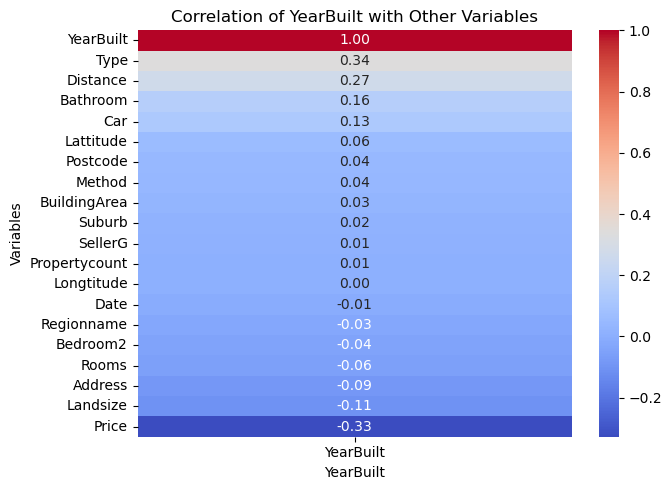

In [144]:
# Compute correlation matrix and visualize correlations with 'YearBuilt'
correlation_matrix_encoded = numeric_and_encoded_columns.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(
    correlation_matrix_encoded[['YearBuilt']].sort_values(by='YearBuilt', ascending=False),
    annot=True, cmap='coolwarm', cbar=True, fmt=".2f"
)
plt.title('Correlation of YearBuilt with Other Variables')
plt.xlabel('YearBuilt')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()

As 'YearBuilt' does not correlate with any other variables over the threshold of 0.25 which would lead to impution with predictors that have a weak or no relationship with 'YearBuilt', and thus lead to values that are not meaningful or accurate. 

Hence, we proceed with other forms of imputation and check for variability across regions.

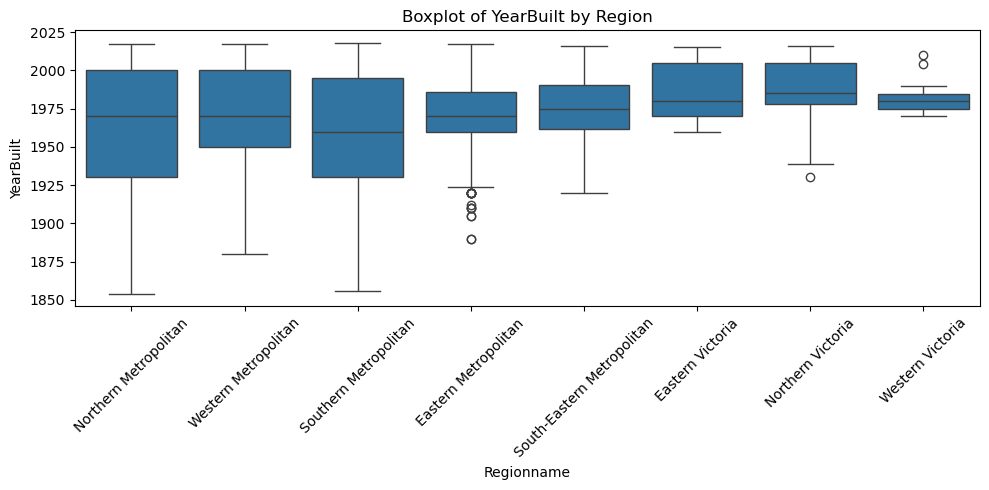

In [145]:
# Boxplot for YearBuilt by Region to check for vraince between the different Regions
plt.figure(figsize=(10, 5))
sns.boxplot(x='Regionname', y='YearBuilt', data=housing_data)
plt.xticks(rotation=45)
plt.title('Boxplot of YearBuilt by Region')
plt.xlabel('Regionname')
plt.ylabel('YearBuilt')
plt.tight_layout()
plt.show()

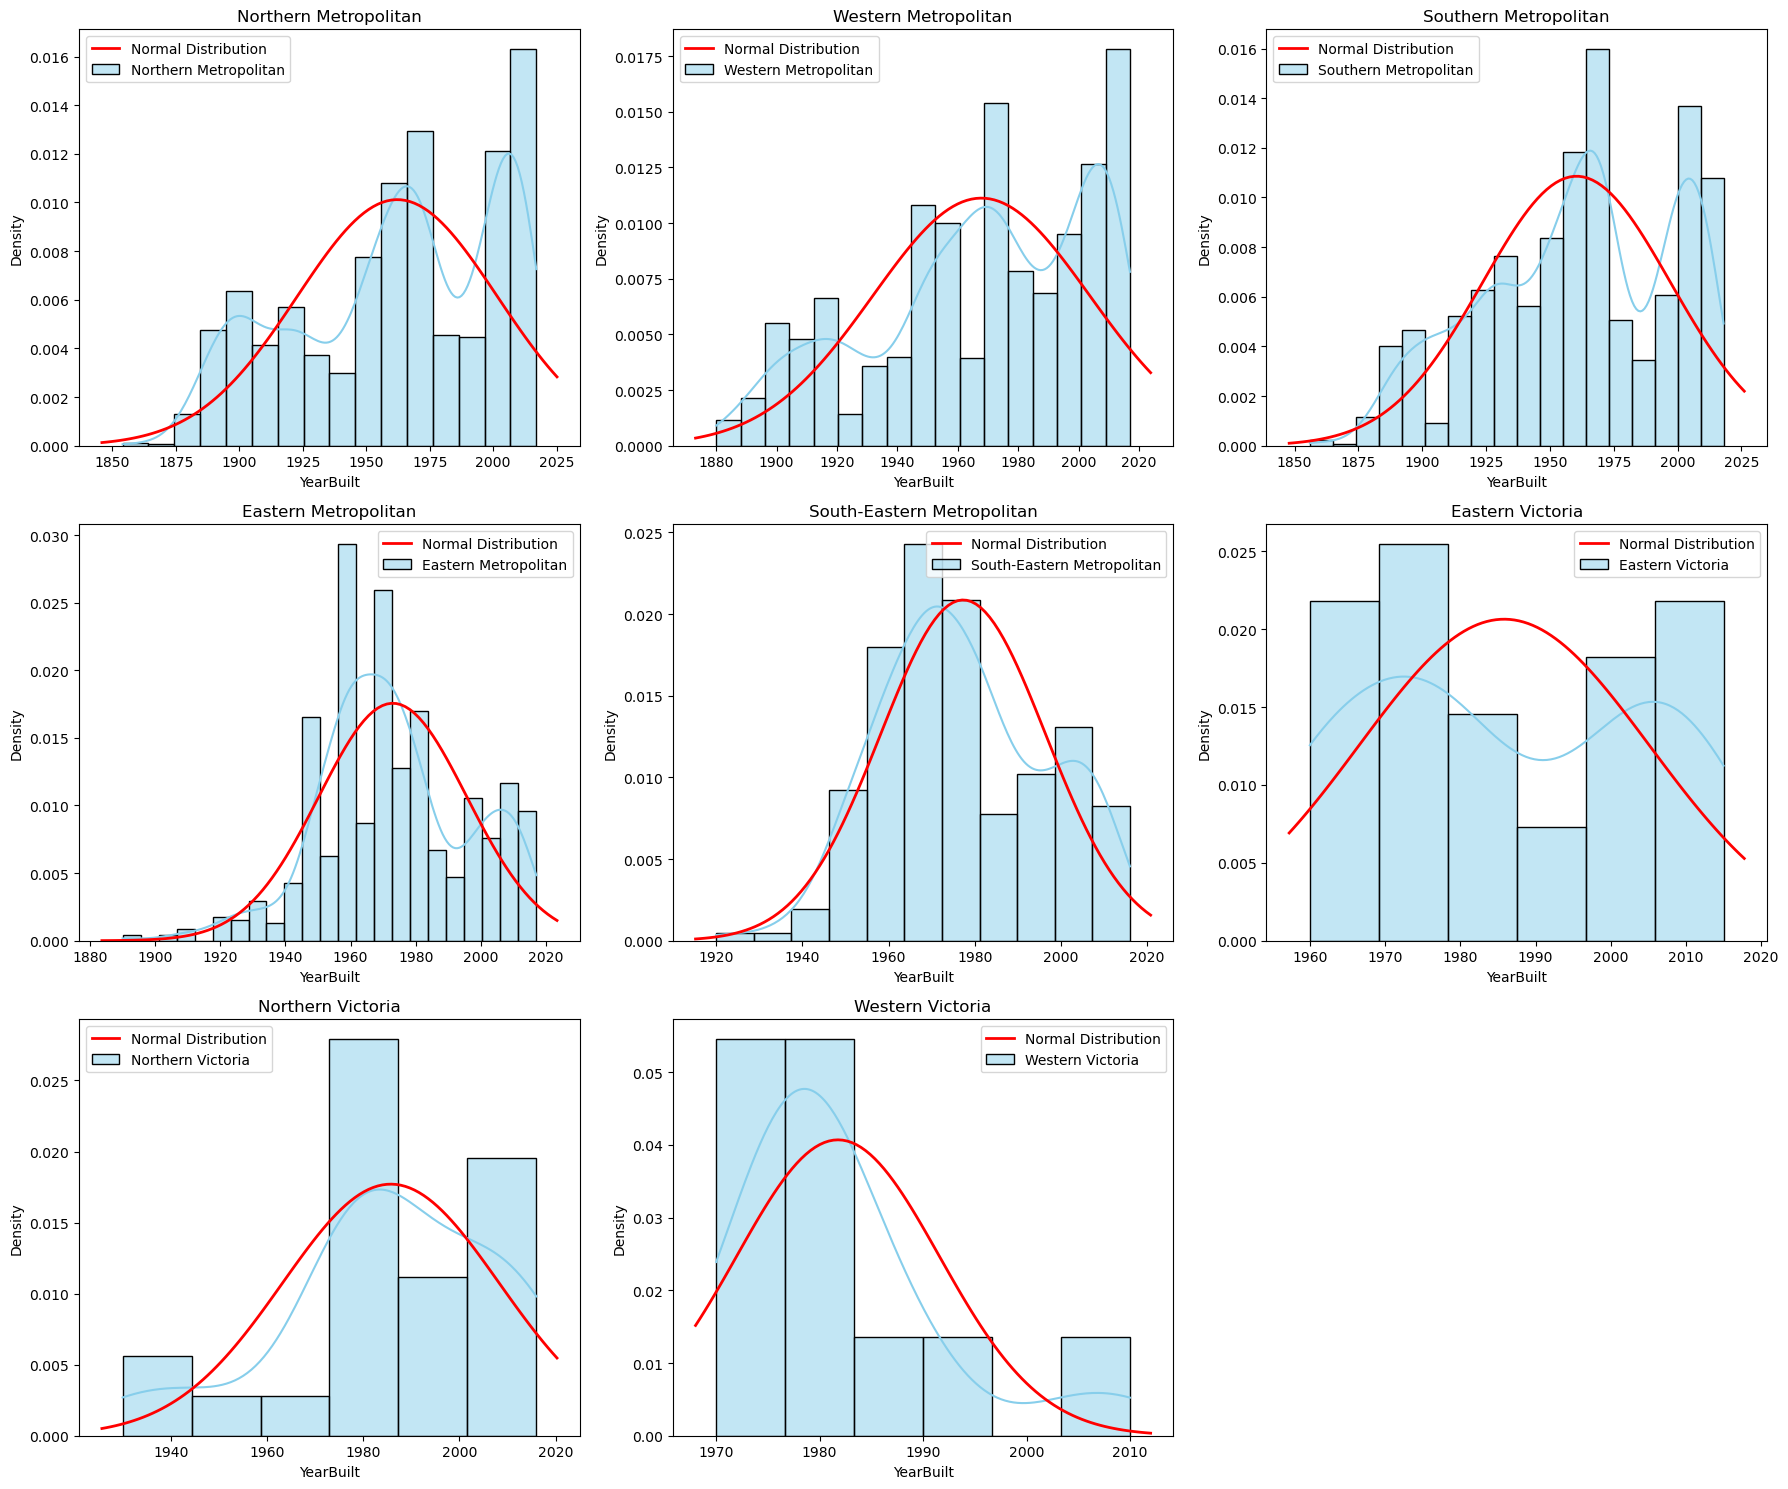

In [146]:
# Check if YearBuilt follows a Normal distirbution
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Group the data by 'Regionname' and prepare for subplots
regions = housing_data['Regionname'].unique()
num_regions = len(regions)

# Determine the number of rows and columns for subplots
rows = int(np.ceil(num_regions / 3))
cols = 3

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5))
axes = axes.flatten()

for i, region in enumerate(regions):
    ax = axes[i]
    # Filter data for the specific region and drop missing YearBuilt values
    region_data = housing_data[housing_data['Regionname'] == region]['YearBuilt'].dropna()
    
    if region_data.empty:
        ax.set_title(f"{region} - No Data")
        ax.axis('off')
        continue

    # Plot histogram and normal distribution
    sns.histplot(region_data, kde=True, stat="density", color='skyblue', ax=ax, label=f"{region}")
    
    # Plot normal distribution
    mean = region_data.mean()
    std = region_data.std()
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean, std)
    ax.plot(x, p, 'r', linewidth=2, label="Normal Distribution")
    ax.set_title(f"{region}")
    ax.legend()

# Remove empty subplots if regions are fewer than rows * cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



We can see from the plots that 'YearBuilt' does not follow a normal distribution within each region. Thus we can not impute 'YearBuilt' by drawing at random from a normal distribution. As variability within the variable is still important, we sample directly sample from the existing observed values in each region. This method ensures that the imputed values align with the actual distribution of 'YearBuilt' within each region, regardless of its shape.

In [147]:
def random_impute_by_region(data, region_col, yearbuilt_col):
    # Iterate through each region
    for region in data[region_col].unique():
        # Filter non-missing values of YearBuilt for the current region
        region_data = data[data[region_col] == region][yearbuilt_col].dropna()
        
        # Check if there are non-missing values to sample from
        if not region_data.empty:
            # Count the number of missing values in YearBuilt for the current region
            missing_count = data[(data[region_col] == region) & (data[yearbuilt_col].isnull())].shape[0]
            
            # Randomly sample values from the existing distribution
            imputed_values = np.random.choice(region_data, missing_count, replace=True)
            
            # Fill the missing values with the sampled values
            data.loc[(data[region_col] == region) & (data[yearbuilt_col].isnull()), yearbuilt_col] = imputed_values

# Apply the function to the housing data
random_impute_by_region(housing_data, 'Regionname', 'YearBuilt')

# Check for remaining missing values
print("Remaining Missing Values in YearBuilt:")
print(housing_data['YearBuilt'].isnull().sum())


Remaining Missing Values in YearBuilt:
0


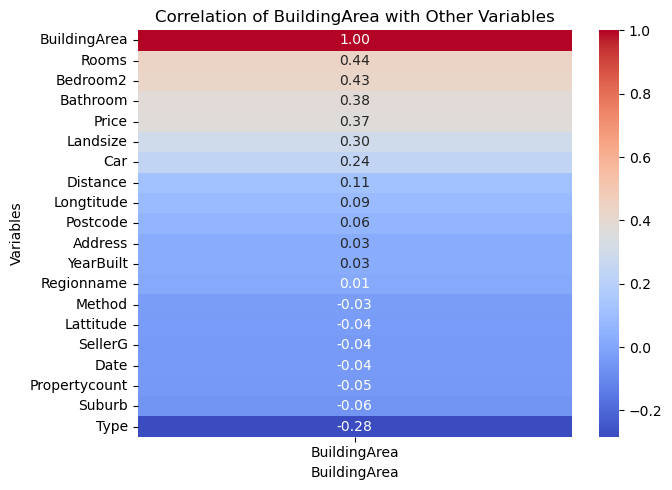

In [148]:
# Compute correlation matrix and visualize correlations with 'BuildingArea'
correlation_matrix_encoded = numeric_and_encoded_columns.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(
    correlation_matrix_encoded[['BuildingArea']].sort_values(by='BuildingArea', ascending=False),
    annot=True, cmap='coolwarm', cbar=True, fmt=".2f"
)
plt.title('Correlation of BuildingArea with Other Variables')
plt.xlabel('BuildingArea')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()

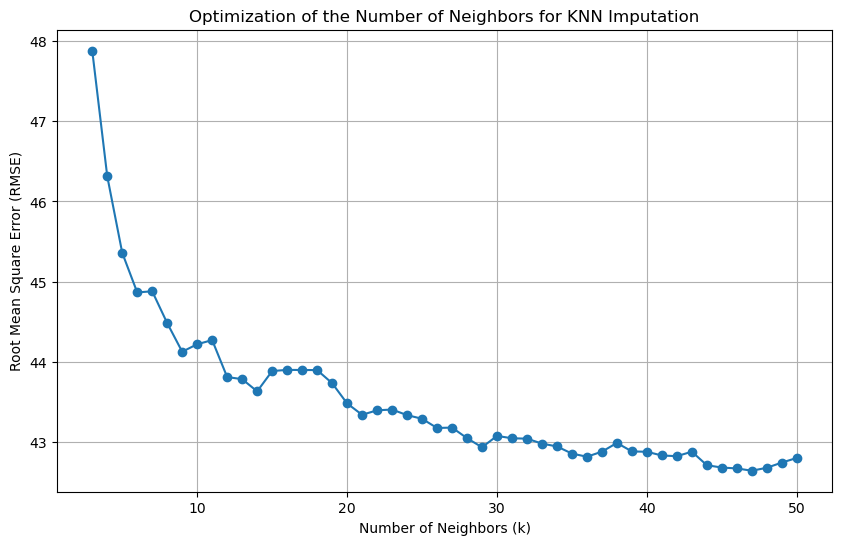

Optimal number of neighbors: 47


In [149]:
# Imputation of BuildingArea using KNN - using variables with a correlation of >= 0.25 (except price)
# Select relevant columns for testing imputation
columns_for_imputation = ['BuildingArea', 'Rooms', 'Bedroom2', 'Bathroom', 'Landsize', 'Type']
housing_data_encoded = housing_data.copy()

# Encode non-numeric columns
if 'Type' in columns_for_imputation:
    housing_data_encoded['Type'] = housing_data_encoded['Type'].astype('category').cat.codes

# Remove rows with missing values for testing
complete_data = housing_data_encoded.dropna(subset=columns_for_imputation)

# Split into train and test
train_data, test_data = train_test_split(complete_data, test_size=0.2, random_state=42)

# Introduce artificial missingness in the 'BuildingArea' column for testing
test_data_missing = test_data.copy()
mask = np.random.rand(len(test_data)) < 0.3  # Mask 30% of the values
test_data_missing.loc[mask, 'BuildingArea'] = np.nan

# Optimize n_neighbors
errors = []
n_neighbors_range = range(3, 51)

for k in n_neighbors_range:
    # Apply KNN imputation
    knn_imputer = KNNImputer(n_neighbors=k)
    imputed_data = knn_imputer.fit_transform(test_data_missing[columns_for_imputation])
    
    # Calculate error
    imputed_values = imputed_data[:, 0]  # Imputed 'BuildingArea'
    true_values = test_data['BuildingArea'].values
    error = root_mean_squared_error(true_values, imputed_values)
    errors.append(error)

# Plot errors to find the optimal n_neighbors
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors_range, errors, marker='o')
plt.title("Optimization of the Number of Neighbors for KNN Imputation")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Root Mean Square Error (RMSE)")
plt.grid()
plt.show()

# Best n_neighbors
best_k = n_neighbors_range[np.argmin(errors)]
print(f"Optimal number of neighbors: {best_k}")



In [150]:
# Use KNN to impute BuildingArea based on variables with a correlation threshold of >= 0.25 (except Price)
# Select relevant columns for imputation
columns_for_imputation = ['BuildingArea', 'Rooms', 'Bedroom2', 'Bathroom', 'Landsize', 'Type']
housing_data_encoded = housing_data.copy()

# Encode non-numeric columns to include in KNN
if 'Type' in columns_for_imputation:
    housing_data_encoded['Type'] = housing_data_encoded['Type'].astype('category').cat.codes

# Apply KNN imputation to selected columns
knn_imputer = KNNImputer(n_neighbors=best_k)
imputed_data = knn_imputer.fit_transform(housing_data_encoded[columns_for_imputation])

# Update the original DataFrame with imputed values
housing_data.loc[:, 'BuildingArea'] = imputed_data[:, 0]

# Check for remaining missing values in 'BuildingArea'
print("Remaining Missing Values in BuildingArea:")
print(housing_data['BuildingArea'].isnull().sum())


Remaining Missing Values in BuildingArea:
0


In [151]:
print("\nPost-Cleaning Missing Data:")
missing_data = housing_data.isnull().sum()
missing_percentage = (missing_data / len(housing_data)) * 100
missing_report = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage': missing_percentage})
print(missing_report[missing_report['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False))


Post-Cleaning Missing Data:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []


In [152]:
# Check for invalid entires in Landsize (where Landsize = 0)
landsizes_equal_zero = (housing_data['Landsize'] == 0).sum()
print(f"Number of Landsize values equal to 0: {landsizes_equal_zero}")

Number of Landsize values equal to 0: 1937


In [153]:
# Update Landsize to be equal to BuildingArea where Landsize is 0
housing_data.loc[housing_data['Landsize'] == 0, 'Landsize'] = housing_data['BuildingArea']
housing_data[['BuildingArea', 'Landsize']]

,BuildingArea,Landsize
0,119.780851,202.0
1,79.000000,156.0
2,150.000000,134.0
3,97.936170,94.0
4,142.000000,120.0
...,...,...
13202,206.584043,652.0
13203,133.000000,333.0
13204,165.085106,436.0
13205,157.000000,866.0


In [154]:
housing_data.to_csv('cleaned_data_without_outliers.csv', index=False)